# Model Prediction with MLflow Model Registry

This notebook demonstrates how to:
1. Load models from MLflow Model Registry
2. Make predictions on test data
3. Evaluate prediction performance
4. Compare different model versions
5. Save predictions for deployment

## Setup and Imports

In [2]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
from mlflow.tracking import MlflowClient
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from taxi_ride.data.preprocess_data import load_pickle, get_project_paths

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Configuration

In [3]:
# Model configuration
MODEL_NAME = "random-forest-taxi-model"

# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
client = MlflowClient()

# Get project paths
paths = get_project_paths()
DATA_PATH = paths["PROCESSED_DATA_DIR"]
MODELS_PATH = paths["MODELS_DIR"]

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Model Name: {MODEL_NAME}")
print(f"Data Path: {DATA_PATH}")
print(f"Models Path: {MODELS_PATH}")

MLflow Tracking URI: http://127.0.0.1:5000
Model Name: random-forest-taxi-model
Data Path: /home/lisanab/fujitsu_laptop_files/MLOps/cookiecutter/cookiecutter-ml-course/data/processed
Models Path: /home/lisanab/fujitsu_laptop_files/MLOps/cookiecutter/cookiecutter-ml-course/models


## Load Test Data

In [4]:
# Load test dataset
X_test, y_test = load_pickle(os.path.join(DATA_PATH, "test.pkl"))

print(f"Test set shape: {X_test.shape}")
print(f"Number of samples: {X_test.shape[0]}")
print(f"Number of features: {X_test.shape[1]}")
print(f"\nTarget statistics:")
print(f"  Mean: {y_test.mean():.2f}")
print(f"  Std: {y_test.std():.2f}")
print(f"  Min: {y_test.min():.2f}")
print(f"  Max: {y_test.max():.2f}")

Test set shape: (61119, 6025)
Number of samples: 61119
Number of features: 6025

Target statistics:
  Mean: 14.64
  Std: 9.94
  Min: 1.00
  Max: 60.00


## View Available Models in Registry

In [7]:
# List all versions of the model
try:
    model_versions = client.search_model_versions(f"name='{MODEL_NAME}'")
    
    print(f"\n=== Available versions of {MODEL_NAME} ===")
    versions_info = []
       
    for mv in model_versions:
        aliases = client.get_model_version(name=MODEL_NAME, version=mv.version).aliases
        versions_info.append({
            "Version": mv.version,
            "Aliases": ", ".join(aliases) if aliases else "None",
            "Status": mv.status,
            "Run_ID": mv.run_id[:8] + "..."
        })
    
    versions_df = pd.DataFrame(versions_info)
    print(versions_df.to_string(index=False))
    
except Exception as e:
    print(f"Error loading model versions: {e}")
    print("Make sure the model is registered in MLflow Model Registry")


=== Available versions of random-forest-taxi-model ===
Version    Aliases Status      Run_ID
      5       None  READY 94f431ac...
      4       None  READY 9eb1d49b...
      3       None  READY a11e3110...
      2 production  READY 110105fb...
      1   champion  READY 110105fb...


## Load Model from Registry

### Option 1: Load Latest Version

In [8]:
print("Loading latest model version...")
model_latest = mlflow.sklearn.load_model(f"models:/{MODEL_NAME}/latest")
print("✓ Latest model loaded successfully")

Loading latest model version...


✓ Latest model loaded successfully


### Option 2: Load Model by Alias (Recommended)

In [9]:
# Load production model using alias
try:
    print("Loading model with 'champion' alias...")
    model_champion = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}@champion")
    print("✓ Champion model loaded successfully")
    
    # Use champion model for predictions
    model = model_champion
except Exception as e:
    print(f"Champion alias not found, using latest: {e}")
    model = model_latest

Loading model with 'champion' alias...


✓ Champion model loaded successfully


### Option 3: Load Specific Version

In [ ]:
# Uncomment to load a specific version
# VERSION = 1
# model = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}/{VERSION}")
# print(f"✓ Model version {VERSION} loaded successfully")

## Make Predictions

In [10]:
print("Generating predictions...")
predictions = model.predict(X_test)
print(f"✓ Generated {len(predictions)} predictions")

print(f"\nPrediction statistics:")
print(f"  Mean: {predictions.mean():.2f}")
print(f"  Std: {predictions.std():.2f}")
print(f"  Min: {predictions.min():.2f}")
print(f"  Max: {predictions.max():.2f}")

Generating predictions...
✓ Generated 61119 predictions

Prediction statistics:
  Mean: 14.79
  Std: 8.00
  Min: 4.37
  Max: 54.63


## Evaluate Predictions

In [11]:
# Calculate metrics
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("=== Model Performance ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# Calculate residuals
residuals = y_test - predictions
print(f"\nResiduals:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std:  {residuals.std():.4f}")

=== Model Performance ===
RMSE: 6.0140
MAE:  3.9288
R²:   0.6338

Residuals:
  Mean: -0.1539
  Std:  6.0121


## Visualize Predictions

### Actual vs Predicted Values

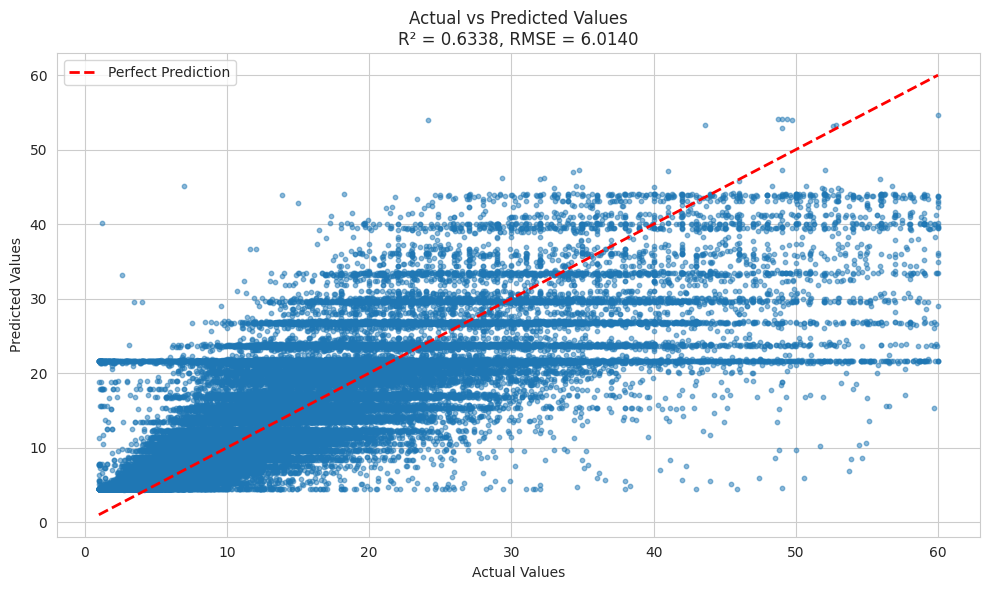

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

### Residuals Distribution

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals histogram
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')

# Residuals vs Predicted
axes[1].scatter(predictions, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

### Prediction Error Analysis

In [ ]:
# Analyze prediction errors
abs_errors = np.abs(residuals)
percentage_errors = (abs_errors / y_test) * 100

print("=== Error Analysis ===")
print(f"Median Absolute Error: {np.median(abs_errors):.4f}")
print(f"Mean Absolute Percentage Error: {percentage_errors.mean():.2f}%")
print(f"\nPercentile Errors:")
print(f"  25th: {np.percentile(abs_errors, 25):.4f}")
print(f"  50th: {np.percentile(abs_errors, 50):.4f}")
print(f"  75th: {np.percentile(abs_errors, 75):.4f}")
print(f"  95th: {np.percentile(abs_errors, 95):.4f}")

## Create Predictions DataFrame

In [14]:
# Create comprehensive predictions dataframe
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': predictions,
    'residual': residuals,
    'abs_error': abs_errors,
    'pct_error': percentage_errors
})

print("=== Sample Predictions ===")
print(predictions_df.head(10))

print("\n=== Predictions Summary ===")
print(predictions_df.describe())

NameError: name 'abs_errors' is not defined

## Identify Best and Worst Predictions

In [13]:
# Best predictions (smallest errors)
print("=== Top 5 Best Predictions ===")
best_predictions = predictions_df.nsmallest(5, 'abs_error')
print(best_predictions)

# Worst predictions (largest errors)
print("\n=== Top 5 Worst Predictions ===")
worst_predictions = predictions_df.nlargest(5, 'abs_error')
print(worst_predictions)

=== Top 5 Best Predictions ===


NameError: name 'predictions_df' is not defined

## Save Predictions

In [ ]:
# Create models directory if it doesn't exist
os.makedirs(MODELS_PATH, exist_ok=True)

# Save predictions as pickle
predictions_pkl_path = os.path.join(MODELS_PATH, "predictions.pkl")
with open(predictions_pkl_path, "wb") as f:
    pickle.dump(predictions, f)
print(f"✓ Predictions saved to: {predictions_pkl_path}")

# Save predictions dataframe as CSV
predictions_csv_path = os.path.join(MODELS_PATH, "predictions.csv")
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"✓ Predictions CSV saved to: {predictions_csv_path}")

## Compare Multiple Model Versions (Optional)

## Summary

This notebook demonstrated:
1. ✅ Loading models from MLflow Model Registry (latest, by alias, by version)
2. ✅ Making predictions on test data
3. ✅ Evaluating prediction performance with multiple metrics
4. ✅ Visualizing predictions and residuals
5. ✅ Analyzing prediction errors
6. ✅ Comparing multiple model versions


**Key Metrics:**
- RMSE: Lower is better (measures average prediction error)
- R²: Higher is better (explains variance, max = 1.0)
- MAE: Lower is better (robust to outliers)

**Next Steps:**
- Deploy model to production
